In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import re
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
df= pd.DataFrame()

df = pd.read_csv('/content/drive/MyDrive/Lab2/texts_train.txt', sep="\t", encoding='UTF-8',header=0)
df['grade'] = pd.read_csv('/content/drive/MyDrive/Lab2/scores_train.txt', sep="\t", encoding='UTF-8',header=0)
df.columns = ['comment', 'grade']
print(df.head())

Mounted at /content/drive
                                             comment  grade
0  думал, что будет лучше идея очень интересна - ...      7
1  с творчеством Головачева я познакомился посред...     10
2  то-то я и в большое неудовольствие прочитал "А...      5
3  как мне показалось местами сильно смахивает на...      6
4  от первой части книги просто оторваться не мог...      9


In [ ]:
unique_grades = np.sort(df['grade'].unique())

df_new = pd.DataFrame()
comment = []
grade = []

for grades in unique_grades:
    counter = 0
    for i in range(len(df)):
    #for i in range(000/(len(unique_grades))):
        if (counter<300):
            if (grades == df['grade'][i]):
                comment.append(df['comment'][i])
                grade.append(df['grade'][i])
                counter = counter + 1
df_new['comment'] = comment
#Заменим значения оценок на 1,2,3
#Это облегчит подсчет ошибки
#1 - негативный отзыв
#2 - нейтральный
#3 - положительный
df_new['grade'] = grade
df_new['grade'] = df_new['grade'].replace(1, 0).replace(2, 0).replace(3, 0)
df_new['grade'] = df_new['grade'].replace(4, 1).replace(5, 1).replace(6, 1).replace(7, 1)
df_new['grade'] = df_new['grade'].replace(10, 2).replace(9, 2).replace(8, 2)
print('new unique grades: ',np.sort(df_new['grade'].unique()))
print(df_new.head())

new unique grades:  [0 1 2]
                                             comment  grade
0  Хотелось долго плеваться после того как я с тр...      0
1  ИМХО, в серии о Свароге Бушков исписался. Если...      0
2  Много был наслышан об этом авторе и вот взялся...      0
3  Да, тяжело читать безграмотную фэнтези. Хотя, ...      0
4  Попытка свести сюжет предыдущих книг в единое ...      0


In [ ]:
df_new

,comment,grade
0,Хотелось долго плеваться после того как я с тр...,0
1,"ИМХО, в серии о Свароге Бушков исписался. Если...",0
2,Много был наслышан об этом авторе и вот взялся...,0
3,"Да, тяжело читать безграмотную фэнтези. Хотя, ...",0
4,Попытка свести сюжет предыдущих книг в единое ...,0
...,...,...
2995,"книга не похожа ни на одну из тех,что вы читал...",2
2996,"к Есенину у меня любовь не просто как к поэту,...",2
2997,"очень чувственно, с болью, настоящей мужской б...",2
2998,"назовите мне писателя, хотя бы близко напомина...",2


In [ ]:
neg = df_new[df_new['grade'] == 0]
neu = df_new[df_new['grade'] == 1]
pos = df_new[df_new['grade'] == 2]

In [ ]:
neg

,comment,grade
0,Хотелось долго плеваться после того как я с тр...,0
1,"ИМХО, в серии о Свароге Бушков исписался. Если...",0
2,Много был наслышан об этом авторе и вот взялся...,0
3,"Да, тяжело читать безграмотную фэнтези. Хотя, ...",0
4,Попытка свести сюжет предыдущих книг в единое ...,0
...,...,...
895,"Мадонна - писательница со стажем: ее книга ""Ан...",0
896,Одним из самых мужских литературных жанров явл...,0
897,"Ну хорошо... я все могу понять, человек любит ...",0
898,"Не знаю, каким юмором можно захлебнуться в это...",0


In [ ]:
neg['sentence_len'] = df_new['comment'].apply(lambda x: len(x.split()))
neu['sentence_len'] = df_new['comment'].apply(lambda x: len(x.split()))
pos['sentence_len'] = df_new['comment'].apply(lambda x: len(x.split()))

<ipython-input-7-6a32acfadad8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['sentence_len'] = df_new['comment'].apply(lambda x: len(x.split()))
<ipython-input-7-6a32acfadad8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neu['sentence_len'] = df_new['comment'].apply(lambda x: len(x.split()))
<ipython-input-7-6a32acfadad8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

<Axes: >

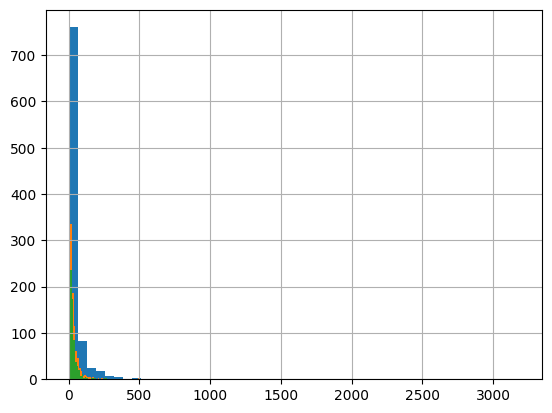

In [ ]:
neg['sentence_len'].hist(bins=50),
neu['sentence_len'].hist(bins=50),
pos['sentence_len'].hist(bins=50)

In [ ]:
print(
  min(neg['sentence_len']), neg['sentence_len'].mean(), max(neg['sentence_len']),
  min(neu['sentence_len']), neu['sentence_len'].mean(), max(neu['sentence_len']),
  min(pos['sentence_len']), pos['sentence_len'].mean(), max(pos['sentence_len']),
)

1 43.59 3187 1 33.41 601 1 32.89 571


In [ ]:
pd.concat([neg['sentence_len'].describe(), neu['sentence_len'].describe(), pos['sentence_len'].describe()], axis=1)

,sentence_len,sentence_len,sentence_len
count,900.000000,1200.000000,900.000000
mean,43.590000,33.410000,32.890000
std,120.413561,48.715102,52.260962
min,1.000000,1.000000,1.000000
25%,10.000000,11.000000,11.000000
50%,22.000000,20.000000,21.000000
75%,42.000000,38.000000,35.000000
max,3187.000000,601.000000,571.000000


In [ ]:
df_new['comm_len'] = df_new['comment'].apply(lambda x: len(x.split()))

In [ ]:
df_new = df_new[df_new['comm_len'] <= 300]

In [ ]:
df_new.groupby(['grade'])['comment'].count()

,comment
grade,
0,889
1,1192
2,891


In [ ]:
df_new = df_new.groupby('grade', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 800), random_state=42))

<ipython-input-14-dac05afb1494>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new = df_new.groupby('grade', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 800), random_state=42))


In [ ]:
df_new['grade'].value_counts()

,count
grade,
0,800
1,800
2,800


In [ ]:
array_of_mean_thensors = []
grade = []
comment = []
uncomtiled_rows = 0

for i in range(len(df_new)):
    try:
        grade.append(df_new['grade'].iloc[i])  # Используем .iloc вместо []
        comment.append(df_new['comment'].iloc[i])
    except Exception as e:
        uncomtiled_rows += 1
        print(f'[ERROR] STR_{i}: {e}')

In [ ]:
uncomtiled_rows

0

In [ ]:
def preproccessing(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in punctuation])
    text = text.split(' ')
    #print ('Number of reviews :', len(text))
    return text

In [ ]:
tokenized_corpus = [preproccessing(i) for i in comment]

In [ ]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
print(vocabulary)

['насколько', 'интересная', 'книга', 'настолько', 'и', 'поганый', 'фильм', 'ужасно', 'испортили', 'растянутый', 'стеб', 'на', 'вышеупомянутые', 'темы', 'любителя', 'было', 'гадко', 'читать', 'про', 'этого', 'американца', 'неинтересно', 'особенно', 'если', 'её', 'после', 'всех', 'оттенков', 'голубого', 'не', 'дочитала', 'бросила', 'забыла', 'эту', 'книгу', 'читалась', 'тяжело', 'с', 'принуждением', 'какоето', 'серенькое', 'произведение', 'попахивает', 'опттимизмом', 'застоем', 'брежневым', 'бездарность', 'пошлятина', 'за', 'будущее', 'просто', 'страшно', 'юмор', 'донцовой', 'весьма', 'сомнителен', 'а', 'рецепты', 'эти', 'знала', 'еще', 'моя', 'бабушка', 'в', 'молодости', 'хотя', 'вы', 'вообще', 'умеете', 'готовить', 'или', 'делаете', 'это', 'плохо', 'то', 'этот', 'набор', 'элементарных', 'блюд', 'для', 'вас', 'отвратительнейшее', 'первая', 'часть', 'ещё', 'хоть', 'както', 'терпима', 'остальные', 'добросовестно', 'до', 'конца', 'очень', 'хотелось', 'бросить', 'но', 'так', 'поняла', 'что'

In [ ]:
def pad_features(reviews_int, seq_length):
    #Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features

In [ ]:
comment_in_num = []
for sentence in tokenized_corpus:
    comment_in_num.append([word2idx[word] for word in sentence])

In [ ]:
comment_in_num

[[0, 1, 2, 3, 4, 5, 6, 7, 8],
 [9, 10, 11, 12, 13, 11, 14],
 [15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  17,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  4,
  32,
  18,
  33,
  34,
  35,
  36,
  4,
  37,
  38],
 [39, 40, 41, 42, 43, 44, 4, 45],
 [46, 4, 47, 48, 49, 50, 51],
 [52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  23,
  66,
  67,
  29,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80],
 [81, 41, 23, 82, 83, 84, 85, 86, 87, 74, 88],
 [89,
  30,
  90,
  91,
  65,
  92,
  93,
  94,
  95,
  96,
  4,
  29,
  97,
  98,
  99,
  100,
  101,
  102,
  4,
  103,
  104,
  96,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  23,
  116,
  117,
  118,
  119,
  74,
  120,
  121,
  122],
 [123, 124, 125, 126, 56, 6, 127, 128, 129, 115],
 [130,
  131,
  132,
  111,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  98,
  142,
  106,
  63,
  143,
  144,
  145,
  29,
  146,


In [ ]:
features = pad_features(comment_in_num, 300)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(features),np.array(grade), test_size=0.20, random_state=42)

In [ ]:
len(X_train), len(X_test), len(features), len(y_train), len(y_test)

(1920, 480, 2400, 1920, 480)

In [ ]:
len(X_train), len(X_test), len(features), len(y_train), len(y_test)

(1920, 480, 2400, 1920, 480)

In [ ]:
pd.DataFrame({'class': y_train}).value_counts()

,count
class,
1,645
2,643
0,632


In [ ]:
pd.DataFrame({'class': y_test}).value_counts()

,count
class,
0,168
2,157
1,155


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.cuda.FloatTensor(X_train), torch.cuda.LongTensor(y_train))
test_data = TensorDataset(torch.cuda.FloatTensor(X_test), torch.cuda.LongTensor(y_test))
# dataloaders
batch_size = 32
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

<ipython-input-31-a32029aae61b>:4: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  train_data = TensorDataset(torch.cuda.FloatTensor(X_train), torch.cuda.LongTensor(y_train))


In [ ]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True, bidirectional=True)

        # dropout layer
        self.dropout = nn.Dropout(0.5)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        #self.sig = nn.Sigmoid()

        # for multiclass classification
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        # lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = lstm_out[:, -1, :]

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)


        # sigmoid function
        # sig_out = self.sig(out)
        # reshape to be batch_size first
        # sig_out = sig_out.view(batch_size, -1)
        # sig_out = sig_out[:, -1] # get last batch of labels


        #soft_out = self.softmax(out)
        #soft_out = soft_out.view(batch_size, -1, self.output_size)
        #soft_out = soft_out[:, -1] # get last batch of labels


        # return last softmax output and hidden state
        return out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())

        return hidden

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocabulary) + 1 # +1 for the 0 padding
output_size = 3
embedding_dim = 300
hidden_dim = 256
n_layers = 2
clip = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(19640, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


In [ ]:
'''

# train for some number of epochs
for e in tqdm.tqdm(range(epochs)):
    # initialize hidden state
    net.train()
    h = net.init_hidden(batch_size)
    epoch_train_loss = []

    # batch loop
    for inputs, labels in train_loader:
        net.train()
        counter += 1

        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        current_batch_size = inputs.size(0)
        h = net.init_hidden(current_batch_size)

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.cuda.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        loss_.append(loss.item())

    losses.append(np.mean(loss_))
    '''

"\n\n# train for some number of epochs\nfor e in tqdm.tqdm(range(epochs)):\n    # initialize hidden state\n    net.train()\n    h = net.init_hidden(batch_size)\n    epoch_train_loss = []\n\n    # batch loop\n    for inputs, labels in train_loader:\n        net.train()\n        counter += 1\n\n        if (train_on_gpu):\n            inputs, labels = inputs.cuda(), labels.cuda()\n\n        # Creating new variables for the hidden state, otherwise\n        # we'd backprop through the entire training history\n        current_batch_size = inputs.size(0)\n        h = net.init_hidden(current_batch_size)\n\n        # zero accumulated gradients\n        net.zero_grad()\n\n        # get the output from the model\n        inputs = inputs.type(torch.cuda.LongTensor)\n        output, h = net(inputs, h)\n\n        # calculate the loss and perform backprop\n        loss = criterion(output.squeeze(), labels.long())\n        loss.backward()\n        # `clip_grad_norm` helps prevent the exploding gradien

In [ ]:
import tqdm
# loss and optimization functions
lr=0.001

#штраф за разницу в 2 класса
class_weights = torch.tensor([1.0, 1.0, 1.5]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5)
# training params
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)
early_stopping_patience = 2
best_loss = np.inf
patience_counter = 0
epochs = 10
best_f1 = 0

train_losses = []
test_losses = []

counter = 0
print_every = 10
# move model to GPU, if available
train_on_gpu = True
net.cuda()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


SentimentLSTM(
  (embedding): Embedding(19640, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [ ]:
import torch
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
for e in tqdm.tqdm(range(epochs)):
    net.train()
    h = net.init_hidden(batch_size)
    epoch_train_loss = []

    for inputs, labels in train_loader:
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        h = net.init_hidden(inputs.size(0))
        net.zero_grad()
        inputs = inputs.type(torch.cuda.LongTensor)

        output, h = net(inputs, h)
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()

        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        epoch_train_loss.append(loss.item())

    avg_train_loss = np.mean(epoch_train_loss)
    train_losses.append(avg_train_loss)

    # Проверка модели на тесте
    net.eval()
    test_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():  # Отключаем градиенты для инференса
        for inputs, labels in test_loader:
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            h = net.init_hidden(inputs.size(0))
            inputs = inputs.type(torch.cuda.LongTensor)

            output, h = net(inputs, h)
            loss = criterion(output.squeeze(), labels.long())
            test_loss += loss.item()

            preds = torch.argmax(output, axis=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Epoch {e+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f} - Accuracy: {accuracy:.3f} - F1: {weighted_f1:.3f}")

    # Обновляем scheduler
    scheduler.step(avg_test_loss)

    # Early stopping
    if weighted_f1 > best_f1:
        best_f1 = weighted_f1
        patience_counter = 0  # Сбросим счетчик, если F1 растет
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {e+1}")
        break

 10%|█         | 1/10 [00:04<00:39,  4.37s/it]

Epoch 1/10 - Train Loss: 0.7017 - Test Loss: 0.5303 - Accuracy: 0.785 - F1: 0.788


 20%|██        | 2/10 [00:08<00:34,  4.34s/it]

Epoch 2/10 - Train Loss: 0.5381 - Test Loss: 0.4766 - Accuracy: 0.817 - F1: 0.817


 30%|███       | 3/10 [00:12<00:30,  4.32s/it]

Epoch 3/10 - Train Loss: 0.4884 - Test Loss: 0.4296 - Accuracy: 0.827 - F1: 0.827


 40%|████      | 4/10 [00:17<00:26,  4.34s/it]

Epoch 4/10 - Train Loss: 0.4683 - Test Loss: 0.4279 - Accuracy: 0.821 - F1: 0.821


 50%|█████     | 5/10 [00:21<00:21,  4.37s/it]

Epoch 5/10 - Train Loss: 0.4678 - Test Loss: 0.4017 - Accuracy: 0.838 - F1: 0.835


 60%|██████    | 6/10 [00:26<00:17,  4.38s/it]

Epoch 6/10 - Train Loss: 0.4465 - Test Loss: 0.4342 - Accuracy: 0.792 - F1: 0.790


 60%|██████    | 6/10 [00:30<00:20,  5.11s/it]

Epoch 7/10 - Train Loss: 0.4376 - Test Loss: 0.4773 - Accuracy: 0.817 - F1: 0.814
Early stopping triggered at epoch 7


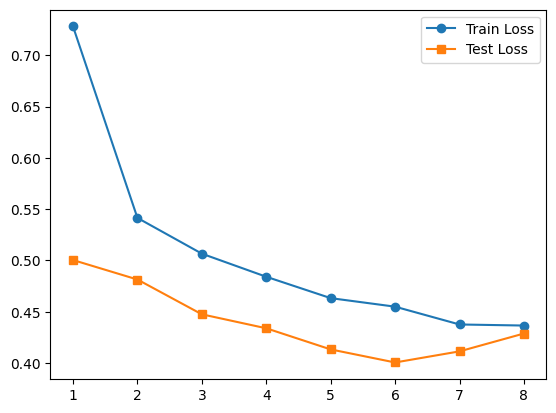

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.legend()

In [ ]:
train_losses, test_losses

([0.7279676243662834,
  0.541465875506401,
  0.5066375906268755,
  0.4841481640934944,
  0.46332051505645117,
  0.45500774184862774,
  0.4376646988093853,
  0.4366242689390977],
 [0.5004312634468079,
  0.4814520219961802,
  0.4475633482138316,
  0.4339488257964452,
  0.41336752971013385,
  0.40064366459846495,
  0.41146684288978574,
  0.4288526256879171])

In [ ]:
# test_losses = [] # track loss
num_correct = 0

# init hidden state
# h = net.init_hidden(batch_size)
y_true, y_pred = [], []
net.eval()


with torch.no_grad():
  for inputs, labels in test_loader:
    current_batch_size = inputs.size(0)
    h = net.init_hidden(current_batch_size)
    h = tuple([each.data for each in h])

    if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

    inputs = inputs.type(torch.cuda.LongTensor)
    output, h = net(inputs, h)
    preds = torch.argmax(output, axis=1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

'''
#iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    current_batch_size = inputs.size(0)
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.cuda.LongTensor)
    output, h = net(inputs, h)

    # calculate loss
    #test_loss = criterion(output.squeeze(), labels.float())
    #test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    preds = torch.argmax(output, axis=1) # rounds to the nearest integer

    # compare predictions to true label
    # correct_tensor = pred.eq(labels.float().view_as(pred))
    # correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # num_correct += np.sum(correct)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


# -- stats! -- ##
# avg test loss
#print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
#test_acc = num_correct/len(test_loader.dataset)
#print("Test accuracy: {:.3f}".format(test_acc))
'''

'\n#iterate over test data\nfor inputs, labels in test_loader:\n\n    # Creating new variables for the hidden state, otherwise\n    # we\'d backprop through the entire training history\n    current_batch_size = inputs.size(0)\n    h = tuple([each.data for each in h])\n\n    if(train_on_gpu):\n        inputs, labels = inputs.cuda(), labels.cuda()\n\n    # get predicted outputs\n    inputs = inputs.type(torch.cuda.LongTensor)\n    output, h = net(inputs, h)\n\n    # calculate loss\n    #test_loss = criterion(output.squeeze(), labels.float())\n    #test_losses.append(test_loss.item())\n\n    # convert output probabilities to predicted class (0 or 1)\n    preds = torch.argmax(output, axis=1) # rounds to the nearest integer\n\n    # compare predictions to true label\n    # correct_tensor = pred.eq(labels.float().view_as(pred))\n    # correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())\n    # num_correct += np.sum(correct)\n\n    y_t

In [ ]:

macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'macro f1: {macro_f1:.3f}')
print(f"Weighted F1-score: {weighted_f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

macro f1: 0.823
Weighted F1-score: 0.824
Accuracy: 0.825


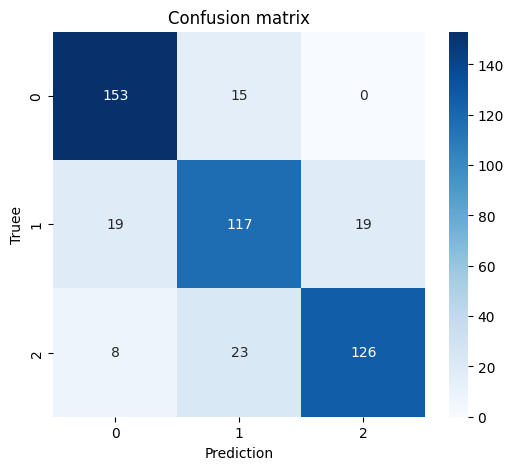

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_true, y_pred)
classes = np.unique(y_true)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Prediction")
plt.ylabel("Truee")
plt.title("Confusion matrix")
plt.show()